# Data Processing Pipeline

In this notebook, we will have the full data processing pipeline for the project.

The goal is to have a clean collaboration network from the Discogs release XML files with:

- Nodes = artists (Discogs artist IDs or their names)
- Edges = collaborations between the artists
- Edge attributes: This will be the release_year, which is actually what will help us in our train/test split processes

The final folders with all our data for now will have the following:
- inside data/final_data_raw: we will have the Discogs '*releases.xml' files which will go as our input in the processing steps
- inside data/final_data_processed: we will have the processed Parquet files which will be the cleaned up data

The outputs from the processing steps will be:
- 'discogs_edges.parquet' with columns as: source_id, target_id, release_year
- 'discogs_artists.parquet' with columns as: discogs_artist_id

In the end, we will use the Spotify metadata, not really will but we might since it is mostly optional, but even if we do we will do it on a subset of artists.


## Imports and Paths

In [3]:
# Note: Handling Imports
import os
import glob
import io
import re
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx

# Note: The following will be our directories, as described earlier
RAW_DATA = '../data/final_data_raw'
PROCESSED_DATA = '../data/final_data_processed'

## Parsing the XML file

For each release in the XML:
- We will extract the released field and pull out the 4-digit year
- We will extract all artists under './artists/artist'
    - We will also use id if present otherwise a fall back will be the name of the artist
- We will only keep the releases with at least 2 artists such that there is some collaboration data
- For such unordered paris of artists, u,v on the same release, we will create the source_id = min(u,v), target_id = max(u,v), and the release year

Also each artists on each edge will be added to the nodes set

In [4]:
# Note: Now we have all the downloaded data in the XML file in the final_data_raw
# Note: The path is ../data/final_data_raw/discogs_20251101_releases.xml
# Note: To get the XML file
xml_file = '../data/final_data_raw/discogs_20251101_releases.xml'
# Note: First step is to initialize the containers
edges, nodes = [], set()

# Note: To get the release year from the xml file, we will use the following pattern
for_year = re.compile(r'(\d{4})') # Note: Since yr will be in 4 digits

# Note: Since we have to parse a very large XML file, currently the raw dataset is 10GB+, we need to do it safely so as to not crash the memory
for event, elem in ET.iterparse(xml_file, events=('end',)):
    if elem.tag == 'release':

        # Note: First step is to extract the release year
        release_year = None
        released_elem = elem.find('released')
        if released_elem is not None and released_elem.text:
            yr = for_year.search(released_elem.text)
            if yr:
                release_year = int(yr.group(1))
        # Note: Next we get all the artists from the song
        artists = [ar.findtext('id') or ar.findtext('name') for ar in elem.findall('./artists/artist')]
        aritsts = [ar for ar in artists if ar]

        # Note: After extracting the artists, we will create the nodes and the edges
        if len(artists) >= 2:
            for i in range(len(artists)):
                nodes.add(aritsts[i])
                for j in range(i+1, len(artists)):
                    edges.append((artists[i], artists[j], release_year)) # Note: Release year is the edge attribute

        # Note: This is the main step, doing elem.clear(), basicalyl frees up the memory for the processed part of XML
        elem.clear()

# Note: After all that is done, print len of nodes and edges to check what we have
print(f'Nodes: {len(nodes)}, Edges: {len(edges)}')

# Reference: https://stackoverflow.com/questions/7171140/using-python-iterparse-for-large-xml-files
# Reference: https://lxml.de/parsing.html#incremental-event-parsing
# Reference: https://boscoh.com/programming/reading-xml-serially.html
# Reference: https://stackoverflow.com/questions/324214/what-is-the-fastest-way-to-parse-large-xml-docs-in-python

FileNotFoundError: [Errno 2] No such file or directory: '../data/final_data_raw/discogs_20251101_releases.xml'

## Convert to DataFrame

Now, that we have our parsed XML file and we have teh edges with source_id, target_id, and release year and our nodes, we can convert them into a pd Dataframe. This will help us inspect the structure, run analysis and save teh data efficiently

We should have:
- Millions of edges
- Hundreds of thousands to millions of artists

Please note that this is not modifying the data but only structuring it for alter processing

In [6]:
# Note: First convert the edges list to DataFrame
edges_df = pd.DataFrame(edges, columns=['source_id', 'target_id', 'release_year'])
# Note: Next we convert the nodes set to DF
artists_df = pd.DataFrame({'discogs_artist_id': list(nodes)})
print(edges_df.head())
print(artists_df.head())
print(f'{len(edges_df)} Edges, {len(artists_df)} Nodes(Artists)')

  source_id target_id  release_year
0        92     17757        1999.0
1     33257      3482        2000.0
2        96        95        1999.0
3     12007    583687        1995.0
4       645      5823        2000.0
  discogs_artist_id
0           9134149
1            403139
2           1983365
3           4570205
4           3566446
7284440 Edges, 1045947 Nodes(Artists)


## Cleaning the Edges

For the link prediction step, it is important to ensure that each edge has a valid release year, and so based on research a small percentage of Discgos entries might not include a year, so these must be removed

- We will remove edges with release_year = None
- This ensures the final dataset will be consisten for our time-based predictions

(Realistically, we are not expecting a big decrease in the number of edges)

In [10]:
# Note: As mentioned, removing edges with no release years
edges_df = edges_df.dropna(subset=['release_year'])
# Note: Later noticed that there are datasets with 0.0 as release_year, so just doing the following too
edges_df = edges_df[edges_df['release_year'] != 0.0]
edges_df['release_year'] = edges_df['release_year'].astype(int)

print(f'Remaining edges: {len(edges_df)}')

Remaining edges: 5673764


## Saving the processed Parquet Files

Now that we have data that is parsed and also cleaned, we will save it inside the data/final_data_processed folder

We will save two files:
- discogs_edges.parquet: Columns will be source_id, target_id, release_year
- discogs_artists.parquet: Columns will be discogs_artist_id

The reason for the Parquet format is it is highly compressed, fast to load, and very ideal for such large datasets with millions of rows

In [11]:
# Note: Defining our paths for output
edges_output = os.path.join(PROCESSED_DATA, 'discogs_edges.parquet')
artists_output = os.path.join(PROCESSED_DATA, 'discogs_artists.parquet')

# Note: Saving our dataframes
edges_df.to_parquet(edges_output, index=False)
artists_df.to_parquet(artists_output, index = False)

# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html

## Spotify Discussion

Realistically speaking, we already have over 1 million nodes and over 5 million edges after cleaning, this dataset is already massive

Link prediction works off of Edges + Graph Structure, for which we have all the rows we need (millions in fact). Spotify would genuinely just be 'extra decoration' to put it that way, it would not really be improving most of our graph link prediction methods, and so we will currently put it on hold and if everything works well with what we have then we do not really need it, since fetching the spotify data for all these artists on its own is damn near impossible. If it seems relevant we will run something for a top N frequent artists, if it seems like that will be handly later on. For now, this concludes our data processing.

## General Link Predicition with Non-Graphical Measures

Here, we will attempt to predict the same edges with a method that doesn't utilize graphical measures. If our hypothesis is correct, this should yield a worse outocme than above. 

In [8]:
df_artistsID = pd.read_parquet("../data/final_data_processed/discogs_artists.parquet")

# print(df.head())

# read the artists xml file so we can use the artist IDs from the parquet file to get artist names
rows = []
for event, elem in ET.iterparse("../data_raw/discogs_20251101_artists.xml", events=("end",)):
    if elem.tag == "artist":   # repeating entry tag for Discogs artists
        row = {child.tag: child.text for child in elem}

        rows.append(row)

        # free memory
        elem.clear()
        parent = elem.getparent() if hasattr(elem, "getparent") else None
        if parent is not None:
            while parent.getprevious() is not None:
                del parent[0]

df_artistsNames = pd.DataFrame(rows)
print(df_artistsNames.head(-5))

               id                    name         realname  \
0               1           The Persuader  Jesper Dahlbäck   
1               2  Mr. James Barth & A.D.              NaN   
2               3               Josh Wink   Josh Winkelman   
3               4           Johannes Heil    Johannes Heil   
4               5              Heiko Laux       Heiko Laux   
...           ...                     ...              ...   
9798342  16856335             Izumi Kohki              NaN   
9798343  16856338                  Kate08        Kate Webb   
9798344  16856341   The Evil B-Side Twins              NaN   
9798345  16856347             Carol Lundy              NaN   
9798346  16856350            문선 (Moonsun)              NaN   

                                                   profile  \
0        Electronic artist working out of Stockholm, ac...   
1                                                      NaN   
2        Electronic music DJ, label owner, producer, an...   
3      

In [24]:
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

load_dotenv()  # loads .env into environment

client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")

auth_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

sp = spotipy.Spotify(auth_manager=auth_manager)

def get_artist(artist, market):
    results = sp.search(q=f"artist:{artist}", type="artist", limit=1, market=market)
    items = results.get("artists", {}).get("items", [])

    
    return items[0] if items else None


def get_artist_data(artist_name, market):
    artist = get_artist(artist_name, market)
    if artist:
        return {
                "genres": artist.get("genres", []),
                "popularity": artist.get("popularity", None),
                "followers": artist.get("followers", {}).get("total", None),
            }
    else:
        return None








# names = []
names_ID = []
dict = {}
count = 0

edges = pd.read_parquet('../data/final_data_processed/discogs_edges.parquet')
edges_sorted = edges.sort_values(by='release_year')

for artist in reversed(edges_sorted['source_id']):
    if len(dict) >= 1000:
        break

    if artist not in dict:
        artist_name = df_artistsNames.loc[df_artistsNames['id'] == artist, 'name'].values
        if artist_name is not None and len(artist_name) > 0 and len(artist_name[0]) > 0:
            time.sleep(0.05)
            artist_data = get_artist_data(artist_name[0], market="US")
            if artist_data is not None:
                # print(artist_data)
                dict[artist] = artist_data
                count += 1
                print(f"{count}/1000")

print(dict)


# names_ID = []

# for name in names:
#     artist_name = df_artistsNames.loc[df_artistsNames['id'] == name, 'name'].values
#     if len(artist_name) > 0:
#         # print(artist_name[0])
#         names_ID.append((artist_name[0], name))
#     else:
#         print("Name not found") 

# print(names_ID[:10])
# # print(len(names_ID))


1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1000
123/1000
1

In [10]:
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

load_dotenv()  # loads .env into environment

client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")

auth_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

sp = spotipy.Spotify(auth_manager=auth_manager)

# testing to see if the API call works
artist = sp.artist("1uNFoZAHBGtllmzznpCI3s")  # Justin Bieber ID
print(artist["name"])



Justin Bieber


In [ ]:
# method 
def get_artist(artist, market):
    results = sp.search(q=f"artist:{artist}", type="artist", limit=1, market=market)
    items = results.get("artists", {}).get("items", [])

    
    return items[0] if items else None


def get_artist_data(artist_name, market):
    artist = get_artist(artist_name, market)
    if artist:
        return {
                "genres": artist.get("genres", []),
                "popularity": artist.get("popularity", None),
                "followers": artist.get("followers", {}).get("total", None),
            }
    else:
        return None

# dict = {}

for name, id in names_ID:
    artist_data = get_artist_data(name, market="US")
    if artist_data is not None:
        # print(artist_data)
        dict[id] = artist_data

# print(dict)


{}


In [ ]:
import math
import random

# write a method to give a probabilty between 0 and 1 of a edge being generated being two artists representing a collaboration
# this will be done without any graphical features and only the metadata retrieved from the spotify API

def predict(artistAInfo, artistBInfo, genreWeight, popularityWeight, followersWeight):

    # define a simple heuristic to determine the probability of collaboration, add a variable "weight" to genre, popularity, followers: genreWeight, popularityWeight, followersWeight

    # Genre Calculation: calculate the number of overlapping genres
    genresA = set(artistAInfo.get("genres", []))
    genresB = set(artistBInfo.get("genres", []))
    genre_overlap = len(genresA.intersection(genresB)) / len(genresA.union(genresB)) if genresA.union(genresB) else 0 # normalizing to something between 0 and 1

    # Popularity Calculation: difference in popularity
    popularityA = artistAInfo.get("popularity", 0)
    popularityB = artistBInfo.get("popularity", 0)
    popularity_diff = abs(popularityA - popularityB)
    popularity_similarity = 1 - (popularity_diff / 100) # normalize to [0, 1]

    # Followers Calculation: difference in followers
    followersA = artistAInfo.get("followers", 0)
    followersB = artistBInfo.get("followers", 0)
    logA = math.log1p(followersA)  # take log to account for large range that could be present
    logB = math.log1p(followersB)
    followers_diff = abs(logA - logB)
    # followers_diff = abs(followersA - followersB)
    followers_similarity = 1 - (followers_diff / 20) # assuming max log difference of 20 for normalization
    
    # final calculation
    probability = genreWeight * genre_overlap + popularityWeight * popularity_similarity + followersWeight * followers_similarity

    probability = min(max(probability, 0), 1) # ensure between 0 and 1

    return probability


def genPredictions(genreWeight, popularityWeight, followersWeight):
    edges_predictions = []

    for artist1 in dict:
        for artist2 in dict:
            if artist1 != artist2:
                prob = predict(dict[artist1], dict[artist2], genreWeight, popularityWeight, followersWeight) # tweaking weights
                edges_predictions.append((artist1, artist2, prob))


    predictedG = nx.Graph()
    predictedG.add_nodes_from(dict.keys())
    for start, end, prob in edges_predictions:
        if random.random() < prob:  # simulate edge creation based on probability
            predictedG.add_edge(start, end)
        

    return predictedG


In [25]:
import numpy as np

df_edges = pd.read_parquet("../data/final_data_processed/discogs_edges.parquet")
df_edges = df_edges[
    (df_edges['release_year'] >= 2000) &
    (df_edges['source_id'].isin(dict.keys()) | df_edges['target_id'].isin(dict.keys()))
]

print(df_edges.head())
print(df_edges.shape)

# graph = genPredictions(0.5, 0.3, 0.2)

# ========= METHOD 1 - Brute Force ==========
maxRelativeCorrect = 0

for genre in np.arange(0, 1, 0.2):
    for popularity in np.arange(0, 1, 0.2):
        for followers in np.arange(0, 1, 0.2):
            print(f"Testing genreWeight: {genre}, popularityWeight: {popularity}, followersWeight: {followers}")
            graph = genPredictions(genre, popularity, followers)
            # print(f"Generated graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
            
            graph_edges = pd.DataFrame(
                [(u, v) for u, v in graph.edges()],
                columns=['start', 'end']
            )

            # print(graph_edges.head())


            edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
            edges2 = set(zip(graph_edges['start'], graph_edges['end']))

            common_edges = edges1 & edges2
            if len(common_edges) > 0 and len(common_edges) / len(edges2) > maxRelativeCorrect:
                maxRelativeCorrect = len(common_edges) / len(edges2)
                # bestGraph = graph
                print(f"New best graph with genreWeight: {genre}, popularityWeight: {popularity}, followersWeight: {followers}, relative correct: {maxRelativeCorrect}")


# # ========= METHOD 2 - Regression ========= (issues of correlation between variables)
# test genre
# maxRelativeCorrect = 0
# genrePoints = []
# for genre in np.arange(0, 1, 0.1):
#     graph = genPredictions(genre, 0.33, 0.33) # choose arbitrary weights for popularity and followers
#     # print(f"Generated graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    
#     graph_edges = pd.DataFrame(
#         [(u, v) for u, v in graph.edges()],
#         columns=['start', 'end']
#     )

#     # print(graph_edges.head())


#     edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
#     edges2 = set(zip(graph_edges['start'], graph_edges['end']))

#     common_edges = edges1 & edges2
#     genrePoints.append((genre, len(common_edges) / len(edges2) if len(edges2) > 0 else 0))
#     if len(common_edges) > 0 and len(common_edges) / len(edges2) > maxRelativeCorrect:
#         maxRelativeCorrect = len(common_edges) / len(edges2)
#         # bestGraph = graph
#         print(f"New best graph with genreWeight: {genre}, popularityWeight: 0.33, followersWeight: 0.33, relative correct: {maxRelativeCorrect}")        

# # test popularity
# maxRelativeCorrect = 0
# popularityPoints = []
# for popularity in np.arange(0, 1, 0.1):
#     graph = genPredictions(0.33, popularity, 0.33) # choose arbitrary weights for genre and followers
#     # print(f"Generated graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    
#     graph_edges = pd.DataFrame(
#         [(u, v) for u, v in graph.edges()],
#         columns=['start', 'end']
#     )

#     # print(graph_edges.head())


#     edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
#     edges2 = set(zip(graph_edges['start'], graph_edges['end']))

#     common_edges = edges1 & edges2
#     popularityPoints.append((popularity, len(common_edges) / len(edges2) if len(edges2) > 0 else 0))
#     if len(common_edges) > 0 and len(common_edges) / len(edges2) > maxRelativeCorrect:
#         maxRelativeCorrect = len(common_edges) / len(edges2)
#         # bestGraph = graph
#         print(f"New best graph with genreWeight: 0.33, popularityWeight: {popularity}, followersWeight: 0.33, relative correct: {maxRelativeCorrect}")

# # test followers
# maxRelativeCorrect = 0
# followersPoints = []
# for followers in np.arange(0, 1, 0.1):
#     graph = genPredictions(0.33, 0.33, followers) # choose arbitrary weights for genre and popularity
#     # print(f"Generated graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    
#     graph_edges = pd.DataFrame(
#         [(u, v) for u, v in graph.edges()],
#         columns=['start', 'end']
#     )

#     # print(graph_edges.head())


#     edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
#     edges2 = set(zip(graph_edges['start'], graph_edges['end']))

#     common_edges = edges1 & edges2
#     followersPoints.append((followers, len(common_edges) / len(edges2) if len(edges2) > 0 else 0))
#     if len(common_edges) > 0 and len(common_edges) / len(edges2) > maxRelativeCorrect:
#         maxRelativeCorrect = len(common_edges) / len(edges2)
#         # bestGraph = graph
#         print(f"New best graph with genreWeight: 0.33, popularityWeight: 0.33, followersWeight: {followers}, relative correct: {maxRelativeCorrect}")



1000
     source_id target_id  release_year
910     207517      3293          2000
1123      8121     10933          2000
1395     12974     12967          2001
1397      4223     68181          2000
1417      4223     68181          2000
(332822, 3)
Testing genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.0
Testing genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.2
New best graph with genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.2, relative correct: 0.0015708451146716933
Testing genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.4
Testing genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.6000000000000001
Testing genreWeight: 0.0, popularityWeight: 0.0, followersWeight: 0.8
Testing genreWeight: 0.0, popularityWeight: 0.2, followersWeight: 0.0
New best graph with genreWeight: 0.0, popularityWeight: 0.2, followersWeight: 0.0, relative correct: 0.009094597086483497
Testing genreWeight: 0.0, popularityWeight: 0.2, followersWeight: 0.2

KeyboardInterrupt: 

In [26]:

popularity = 0
followers = 0

for genre in np.arange(0.1, 1.5, 0.1):
    graph = genPredictions(genre, popularity, followers)
    # print(f"Generated graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

    graph_edges = pd.DataFrame(
        [(u, v) for u, v in graph.edges()],
        columns=['start', 'end']
    )

    # print(graph_edges.head())


    edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
    edges2 = set(zip(graph_edges['start'], graph_edges['end']))

    common_edges = edges1 & edges2
    maxRelativeCorrect = len(common_edges) / len(edges2)
    print(f"Best graph with genreWeight: {genre}, popularityWeight: {popularity}, followersWeight: {followers}, relative correct: {maxRelativeCorrect}")

Best graph with genreWeight: 0.1, popularityWeight: 0, followersWeight: 0, relative correct: 0.1827309236947791
Best graph with genreWeight: 0.2, popularityWeight: 0, followersWeight: 0, relative correct: 0.20512820512820512


KeyboardInterrupt: 

## Evaluation - Using genre weight = 1
AUC, Precision, recall, PR-AUC, Hits@K, score distribution


AUC: 0.5352215693402189
Precision: 0.20952677459526775
Recall: 0.6403425309229306
Hits@1000: 0.0014


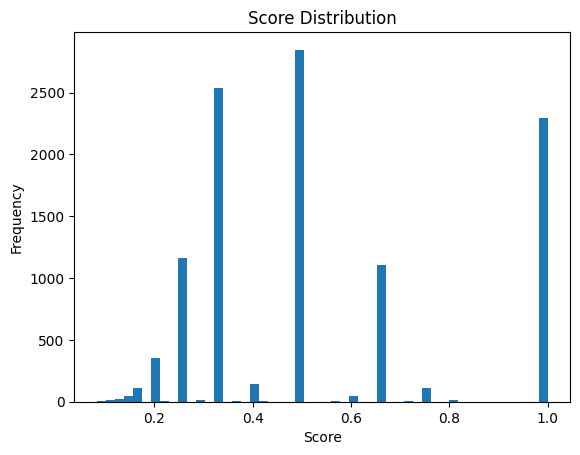

In [27]:
import matplotlib.pyplot as plt

# ========== AUC ==========
from sklearn.metrics import roc_auc_score

graph = genPredictions(1, 0, 0)

graph_edges = pd.DataFrame(
    [(u, v) for u, v in graph.edges()],
    columns=['start', 'end']
)

edges1 = set(zip(df_edges['source_id'], df_edges['target_id']))
edges2 = set(zip(graph_edges['start'], graph_edges['end']))

# loop through and get y_true and y_scores
y_true = []
y_scores = []
for edge in edges2:
    if edge in edges1:
        y_true.append(1)
    else:
        y_true.append(0)
    
    # get the probability score
    prob = predict(dict[edge[0]], dict[edge[1]], 1, 0, 0)
    y_scores.append(prob)

auc = roc_auc_score(y_true, y_scores)
print(f"AUC: {auc}")

# ========== Precision ==========
y_pred = [1 if s >= 0.5 else 0 for s in y_scores]

from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

# ========== Recall ==========
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

# ========== Hits@K ==========
K = 1000

predicted_edges = pd.DataFrame({
    'edge': list(edges2),
    'score': y_scores
})

# Sort by score descending
predicted_edges_sorted = predicted_edges.sort_values('score', ascending=False)

# Take top K edges
top_k_edges = set(predicted_edges_sorted['edge'].iloc[:K])

# Count how many true edges are in top K
hits = sum(1 for edge in edges1 if edge in top_k_edges)

# Compute Hits@K
hits_at_k = hits / len(edges1)
print(f"Hits@{K}: {hits_at_k:.4f}")

# ========== Score Distribution ==========
plt.hist(y_scores, bins=50)
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()





In [29]:
from pathlib import Path

out_path = Path("../gephi_data")

nx.write_gexf(graph, out_path / "nongraphical_predictions.gexf")
